This notebook outlines the data prepration process involved in creating the dataset used in my blogpost on graph neural networks for position classification in soccer. Feel free to use this notebook as a template to generate your own datasets for network analysis/graph neural networks.

In [1]:
%matplotlib inline

import json
import os
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Aquiring the dataset 

The base dataset we will use for this tutorial will be the StatsBomb open event dataset. This dataset contains match and event (passes, shots, etc.) data (in JSON) for 1096 matches between 16-08-2003 and 11-07-2021. However for the purposes of this data preparation tutorial, we will just be focusing on the 51 matches from EURO 2020

Getting access to the data is very straightforward, you can simply clone the [StatsBomb open data repository](https://github.com/statsbomb/open-data) to your local machine.

Once downloaded, you will see all the data we need within the data subdirectory. You will also find a guide on how each of the match and event files relate to each other on the homepage of the repository.

# Import the data 

Once we have the repositiory downloaded, we can iterate through the `JSON` data provided and create both match and passing event datasets.

## Match data

To import the match data, we simply iterate through the `/matches` subdirectory and pull out the main informarion for each match in the dataset. This gives us a dictionary of 1,096 matches which we then convert to a dataframe and filter down to data related to Euro 2020.

In [3]:
rootdir = 'open-data/data/matches'
# we will use this list to store our clean data and convert it to a dataframe
match_data_clean = []

# loop through each file in the matches directory
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        with open(os.path.join(subdir, file)) as json_file:
            # convert JSON to a list of dicts 
            matches = json.load(json_file)
            for match in matches:
                # extract the match info we may want and append to clean data list
                match_data_clean.append(
                    {
                        'match_id': match['match_id'],
                        'match_date': match['match_date'],
                        'competition': match['competition']['competition_name'],
                        'season': match['season']['season_name'],
                        'home_team_id': match['home_team']['home_team_id'],
                        'home_team': match['home_team']['home_team_name'],
                        'away_team': match['away_team']['away_team_name'],
                        'away_team_id': match['away_team']['away_team_id'],
                        'home_score': match['home_score'],
                        'away_score': match['away_score'],
                    }
                )
# convert to dataframe
match_df = pd.DataFrame(match_data_clean)
match_df["match_date"] = pd.to_datetime(match_df["match_date"])

print(f"There are {len(match_df)} total matches in this dataset")

# Filter down to the euro 2020 matches
match_df = match_df.loc[
    (match_df["competition"] == "UEFA Euro") &
    (match_df["season"] == "2020")
]
print(f"There are {len(match_df)} matches from Euro 2020")
match_df.sort_values(by="match_date").tail(10)

There are 1096 total matches in this dataset
There are 51 matches from Euro 2020


,match_id,match_date,competition,season,home_team_id,home_team,away_team,away_team_id,home_score,away_score
983,3794686,2021-06-28,UEFA Euro,2020,785,Croatia,Spain,772,3,5
982,3794692,2021-06-29,UEFA Euro,2020,790,Sweden,Ukraine,911,1,2
981,3794688,2021-06-29,UEFA Euro,2020,768,England,Germany,770,2,0
1013,3795108,2021-07-02,UEFA Euro,2020,773,Switzerland,Spain,772,1,1
978,3795107,2021-07-02,UEFA Euro,2020,782,Belgium,Italy,914,1,2
1015,3795109,2021-07-03,UEFA Euro,2020,912,Czech Republic,Denmark,776,1,2
1014,3795187,2021-07-03,UEFA Euro,2020,911,Ukraine,England,768,0,4
1011,3795220,2021-07-06,UEFA Euro,2020,914,Italy,Spain,772,1,1
979,3795221,2021-07-07,UEFA Euro,2020,768,England,Denmark,776,2,1
980,3795506,2021-07-11,UEFA Euro,2020,914,Italy,England,768,1,1


## Passing event data 

Once we have the a dataframe of matches, we can iterate through the the files in the `/events` subdirectory and start processing events for m`match_id`'s that appear in our matches dataframe.

When processing this data, we will just look for passing events (`event['type']['name'] == 'Pass'`) that were completed to another player on the same team.

Once we identify a passing event that meets this criteria we will store the main information required about the event (you can see these fields below), by parsing the JSON for that passing event.

In [11]:
euro_match_ids = list(match_df["match_id"])

event_data_dir = 'open-data/data/events'
events_data = []
test = None
for filename in os.listdir(event_data_dir):
    if filename.endswith(".json"): 
        with open(os.path.join(event_data_dir, filename)) as json_file:
            match_id = int(filename[:-5])
            # only process the data if its an arsenal match
            if match_id in euro_match_ids:
                data = json.load(json_file)
                for event in data:
                    # only pull pass events
                    if event['type']['name'] == 'Pass':
                        # need some logic for pass vs shot for some fields (easier to do outside the append)
                        outcome = event['pass']['outcome']['name'] if event['pass'].get('outcome') else 'Complete'
                        to = event['pass']['recipient']['name'] if event['pass'].get('recipient') else None
                        if outcome == "Complete" and to is not None:
                            test = event
                            events_data.append(
                                {
                                    'match_id': match_id,
                                    "period": event["period"],
                                    'timestamp': event['timestamp'],
                                    'team_id': event["team"]["id"],
                                    'team_name': event["team"]["name"],
                                    'possession_id':event['possession'],
                                    'from_position_x': event['location'][0],
                                    'from_position_y': event['location'][1],
                                    'from_player_id': event['player']['id'],
                                    'from_player': event['player']['name'],
                                    'from_position': event['position']['name'],
                                    'to_player_id': event['pass']['recipient']['id'] if event['pass'].get('recipient') else None,
                                    'to_player': event['pass']['recipient']['name'] if event['pass'].get('recipient') else None,
                                    "outcome": outcome
                                }
                            )
# convert to dataframe
events_df = pd.DataFrame(events_data)

print('Done')
events_df.head()

Done


,match_id,period,timestamp,team_id,team_name,possession_id,from_position_x,from_position_y,from_player_id,from_player,from_position,to_player_id,to_player,outcome
0,3788742,1,00:00:00.809,776,Denmark,2,60.0,40.0,21261,Jonas Older Wind,Center Forward,3043,Christian Dannemann Eriksen,Complete
1,3788742,1,00:00:02.163,776,Denmark,2,59.5,40.0,3043,Christian Dannemann Eriksen,Right Center Midfield,6797,Daniel Wass,Complete
2,3788742,1,00:00:05.061,776,Denmark,2,68.5,73.4,6797,Daniel Wass,Right Back,5536,Yussuf Yurary Poulsen,Complete
3,3788742,1,00:00:32.617,1835,Finland,3,24.4,20.0,24455,Paulus Arajuuri,Center Back,16550,Jere Juhani Uronen,Complete
4,3788742,1,00:00:33.243,1835,Finland,3,30.4,14.1,16550,Jere Juhani Uronen,Left Wing Back,26939,Joona Toivio,Complete


## Position data

Once we have the match and passing events data processed, we can begin to look at player positions.

### Create a mapping of StatsBomb positions to a more aggregated level

The statsbomb data maps players to a wide variety of positions (Right Center Back, Right Back, Center Midfield, Left Attacking Midfield, etc.), however for the purposes of this tutorial, given the size of the dataset we will be using, we are going to aggregate these granular positions to the following categories:

- Goalkeeper
- Defender
- Midfield
- Forward

To perform this mapping I just created a `positions_mapping.csv` externally and mapped each of the granular positions to one of these 4 aggregated positions before importing it below.

In [12]:
# First export distinct positions to csv
events_df["from_position"].drop_duplicates().to_csv("positions_list.csv", index=False)

# then re-import it as a mapping file
positions_mapping = pd.read_csv("positions_mapping.csv")
positions_mapping.head()

,statsbomb_position,mapped_position
0,Goalkeeper,Goalkeeper
1,Center Back,Defender
2,Right Center Back,Defender
3,Left Center Back,Defender
4,Right Back,Defender


### Figure out where each plyer started the match 

Since players can change positions during a match (e.g. a left back may end up playing as a left winger if a team is chasing the match) we will identify the position that each player started the match in and use that as the players position for that match in the modelling later.

To do this we will simply conver the `period` (the half of the game or extra time) and `timestamp` to seconds and get the first position for each player based on that timestamp using a `groupby` and `rank` in pandas. We will then join on our aggregated positions mapping table from above to get a dataframe of where each player started each match.

In [13]:
def get_seconds(timestamp: str) -> float:
    h, m, s = timestamp.split(':')
    return int(h) * 3600 + int(m) * 60 + float(s)

In [14]:
# get a distinct list of player positiuons per match
players_match_positions = events_df[
    ["match_id", "period", "timestamp", "from_player_id", "from_position"]
]

# timestamp is a string so convert to seconds as a float (to rank)
players_match_positions["timestamp_seconds"] = players_match_positions["timestamp"].apply(
    get_seconds
)
players_match_positions["timestamp_seconds"] = players_match_positions["timestamp_seconds"] * players_match_positions["period"]

players_match_positions = players_match_positions.sort_values(by="timestamp_seconds").drop_duplicates(
    subset=["match_id", "from_player_id", "from_position"],
    keep="first"
)


# figure out where they started the match
players_match_positions["time_rank"] = players_match_positions.groupby(
    ["match_id", "from_player_id"]
)["timestamp_seconds"].rank()

players_match_positions = players_match_positions.loc[players_match_positions["time_rank"] == 1]

# join the mapping data
players_match_positions = players_match_positions.merge(
    positions_mapping,
    left_on="from_position",
    right_on="statsbomb_position"
)

# Remove unnessecary columns to create mapping
players_match_positions = players_match_positions[["match_id", "from_player_id", "mapped_position"]]
players_match_positions.columns = ["match_id", "player_id", "position"]
players_match_positions.head()

/var/folders/df/ngqyz0jx3ml1vb4mkbk46wwr0000gn/T/ipykernel_10687/1523058167.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_match_positions["timestamp_seconds"] = players_match_positions["timestamp"].apply(
/var/folders/df/ngqyz0jx3ml1vb4mkbk46wwr0000gn/T/ipykernel_10687/1523058167.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_match_positions["timestamp_seconds"] = players_match_positions["timestamp_seconds"] * players_match_positions["period"]


,match_id,player_id,position
0,3788762,5660,Midfield
1,3794692,11000,Midfield
2,3788747,18879,Midfield
3,3795187,16514,Midfield
4,3788766,7024,Midfield


## Remove players with little involvement in matches

Players who make short cameos from the bench (e.g. come on for 5-10 minutes at the end of a match) may cause noise in the modelling process, and with this in mind we will remove those from our dataset. To do this, I just aggregated and plotted the distribution of passing events per players and chose an arbitrary cutoff of 10 passes.

Once this cutoff value was decided I filtered down the aggregated data to get a list of players who performed <= 10 passes in a match and removed joined that list onto our main events data (on both the `from_player_id` and `to_player_id`) before removing any players with low involvement.

In [15]:
player_involvement_df = events_df.groupby(["match_id", "from_player_id"])["from_player"].count().reset_index()
player_involvement_df.columns = ["match_id", "player_id", "number_of_passes"]

player_involvement_df.head()

,match_id,player_id,number_of_passes
0,3788741,6954,78
1,3788741,6964,43
2,3788741,6971,8
3,3788741,6993,10
4,3788741,7024,76


/var/folders/df/ngqyz0jx3ml1vb4mkbk46wwr0000gn/T/ipykernel_10687/3326033989.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


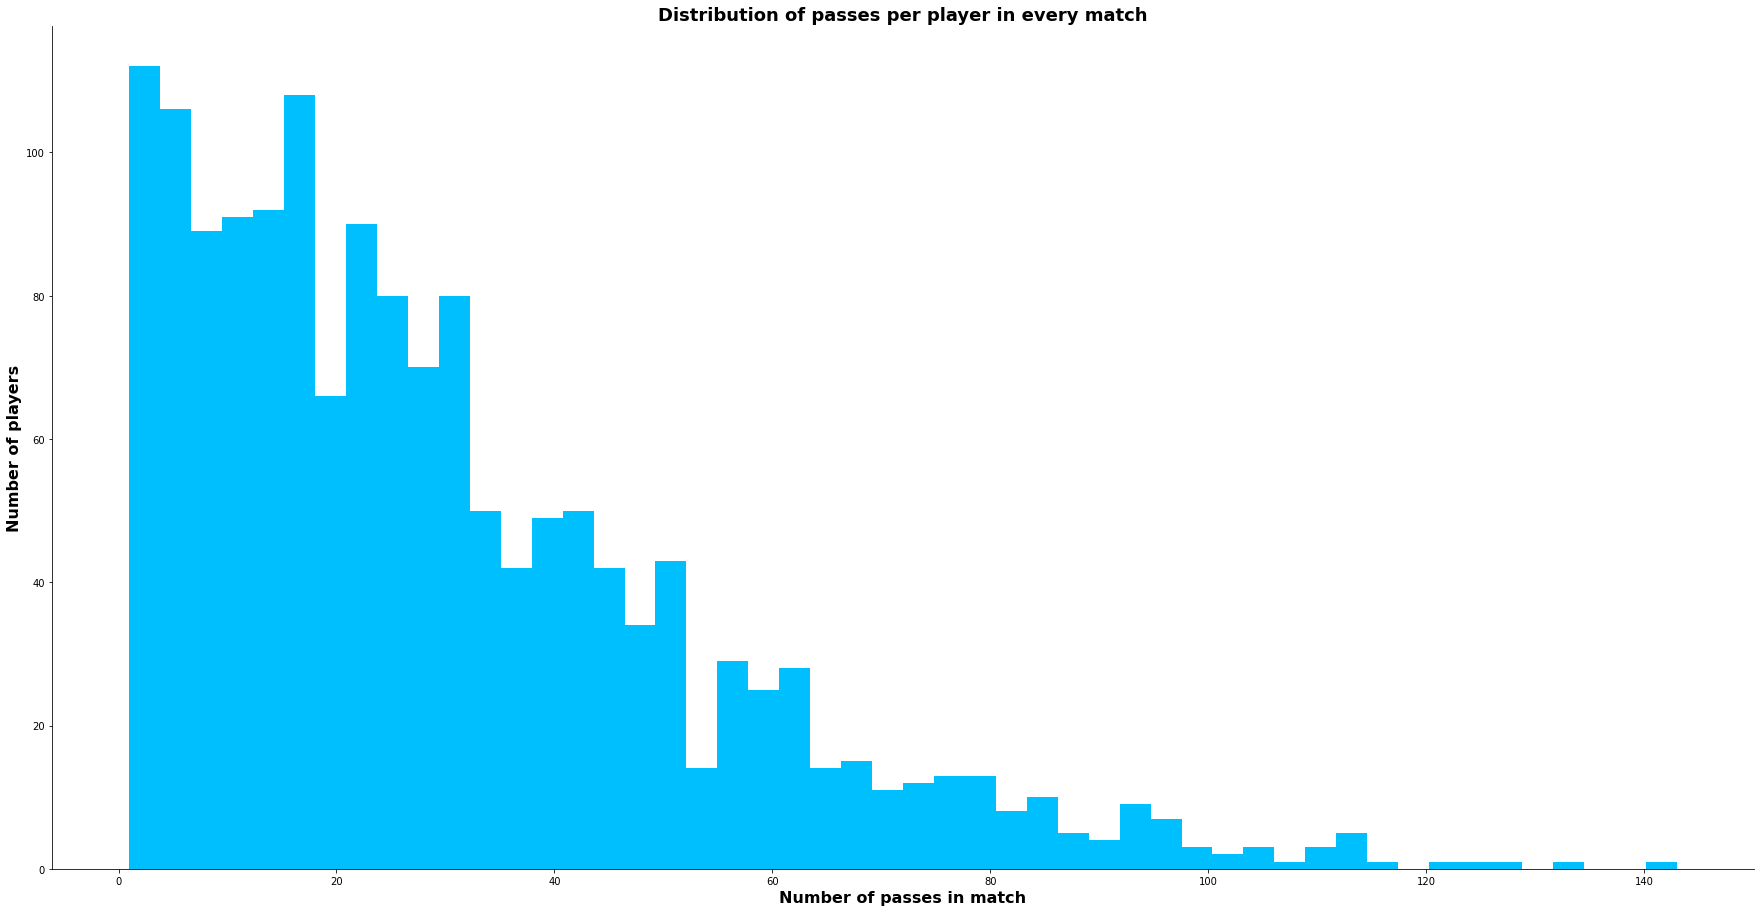

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(30.5, 15.5)

# plot the distribution and overlay
plt.hist(
    x="number_of_passes", bins=50, data=player_involvement_df, color='deepskyblue'
)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# set and format titles
ax.set_title("Distribution of passes per player in every match", fontdict={'fontsize':18, 'fontweight':'bold'})
ax.set_xlabel("Number of passes in match", fontdict={'fontsize':16, 'fontweight':'bold'})
ax.set_ylabel("Number of players", fontdict={'fontsize':16, 'fontweight':'bold'})
plt.savefig('visuals/passes_per_match_distribution.png')
fig.show()

In [17]:
player_with_low_involvement = player_involvement_df.loc[
    player_involvement_df["number_of_passes"] <= 10
]

player_with_low_involvement.head()

,match_id,player_id,number_of_passes
2,3788741,6971,8
3,3788741,6993,10
10,3788741,7156,2
12,3788741,7471,3
13,3788741,7777,3


In [18]:
# first remove any passes FROM low involvement players
events_df = events_df.merge(
    player_with_low_involvement, 
    how="left", 
    left_on=["match_id", "from_player_id"], 
    right_on=["match_id", "player_id"]
)
events_df = events_df.loc[
    events_df["number_of_passes"].isna(),
].drop(["player_id", "number_of_passes"], axis=1)

# then any passes TO low involvement players
events_df = events_df.merge(
    player_with_low_involvement, 
    how="left", 
    left_on=["match_id", "to_player_id"], 
    right_on=["match_id", "player_id"]
)
events_df = events_df.loc[
    events_df["number_of_passes"].isna(),
].drop(["player_id", "number_of_passes"], axis=1)

events_df.head()

,match_id,period,timestamp,team_id,team_name,possession_id,from_position_x,from_position_y,from_player_id,from_player,from_position,to_player_id,to_player,outcome
0,3788742,1,00:00:00.809,776,Denmark,2,60.0,40.0,21261,Jonas Older Wind,Center Forward,3043,Christian Dannemann Eriksen,Complete
1,3788742,1,00:00:02.163,776,Denmark,2,59.5,40.0,3043,Christian Dannemann Eriksen,Right Center Midfield,6797,Daniel Wass,Complete
2,3788742,1,00:00:05.061,776,Denmark,2,68.5,73.4,6797,Daniel Wass,Right Back,5536,Yussuf Yurary Poulsen,Complete
3,3788742,1,00:00:32.617,1835,Finland,3,24.4,20.0,24455,Paulus Arajuuri,Center Back,16550,Jere Juhani Uronen,Complete
4,3788742,1,00:00:33.243,1835,Finland,3,30.4,14.1,16550,Jere Juhani Uronen,Left Wing Back,26939,Joona Toivio,Complete


## Join on the position data 

Here we just simply join on the aggregatated position mappings per match created earlier to our events dataframe.

In [19]:
# Same as before just join on FROM, then join on TO (done in one step here)
events_df = events_df.merge(
    players_match_positions, 
    how="left", 
    left_on=["match_id", "from_player_id"], 
    right_on=["match_id", "player_id"]
).drop(["player_id"], axis=1).merge(
    players_match_positions, 
    how="left", 
    left_on=["match_id", "to_player_id"], 
    right_on=["match_id", "player_id"]
).drop(["player_id"], axis=1)

events_df.head()


,match_id,period,timestamp,team_id,team_name,possession_id,from_position_x,from_position_y,from_player_id,from_player,from_position,to_player_id,to_player,outcome,position_x,position_y
0,3788742,1,00:00:00.809,776,Denmark,2,60.0,40.0,21261,Jonas Older Wind,Center Forward,3043,Christian Dannemann Eriksen,Complete,Forward,Midfield
1,3788742,1,00:00:02.163,776,Denmark,2,59.5,40.0,3043,Christian Dannemann Eriksen,Right Center Midfield,6797,Daniel Wass,Complete,Midfield,Defender
2,3788742,1,00:00:05.061,776,Denmark,2,68.5,73.4,6797,Daniel Wass,Right Back,5536,Yussuf Yurary Poulsen,Complete,Defender,Forward
3,3788742,1,00:00:32.617,1835,Finland,3,24.4,20.0,24455,Paulus Arajuuri,Center Back,16550,Jere Juhani Uronen,Complete,Defender,Defender
4,3788742,1,00:00:33.243,1835,Finland,3,30.4,14.1,16550,Jere Juhani Uronen,Left Wing Back,26939,Joona Toivio,Complete,Defender,Defender


## Remove unnessecary columns

Tidy up the columns to what is required by our analysis.

In [20]:
passing_network_df = events_df [
    [
        "match_id", 
        "team_id", 
        "from_player_id", 
        "position_x", 
        "to_player_id", 
        "position_y", 
        "from_position_x", 
        "from_position_y"
    ]
]
passing_network_df.columns = [
    "match_id", 
    "team_id", 
    "from_player_id", 
    "from_position", 
    "to_player_id", 
    "to_position", 
    "from_position_x", 
    "from_position_y"
]


## Encode the  `from_position` as an integer so we can use it as in input to out classification model

Here we will encode our aggregated position (e.g. Goalkeeper, Defender, etc.) to an integer so we can use it as an input to our model.

To do this, we will make use of sklearn's `LabelEncoder` which makes this transformation handy for us.

In [21]:
position_encoder = LabelEncoder()
passing_network_df["from_position_encoded"] = position_encoder.fit_transform(passing_network_df['from_position']).tolist()

/var/folders/df/ngqyz0jx3ml1vb4mkbk46wwr0000gn/T/ipykernel_10687/1119067923.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passing_network_df["from_position_encoded"] = position_encoder.fit_transform(passing_network_df['from_position']).tolist()


## Remove any nulls and output to CSV 

There are some instances where there is missing data in the dataset. This may cause issues with our modelling later on so we just remove these before expoirting the full dataset created to csv format.

In [22]:
passing_network_df.isna()
passing_network_df[~passing_network_df.isna().any(axis=1)]

,match_id,team_id,from_player_id,from_position,to_player_id,to_position,from_position_x,from_position_y,from_position_encoded
0,3788742,776,21261,Forward,3043,Midfield,60.0,40.0,1
1,3788742,776,3043,Midfield,6797,Defender,59.5,40.0,3
2,3788742,776,6797,Defender,5536,Forward,68.5,73.4,0
3,3788742,1835,24455,Defender,16550,Defender,24.4,20.0,0
4,3788742,1835,16550,Defender,26939,Defender,30.4,14.1,0
...,...,...,...,...,...,...,...,...,...
41933,3795108,772,3957,Defender,5203,Midfield,68.9,47.6,0
41934,3795108,772,3957,Defender,5208,Midfield,71.1,38.2,0
41935,3795108,772,5208,Midfield,5211,Defender,73.9,23.7,3
41936,3795108,772,5211,Defender,6685,Forward,91.8,3.1,0


In [23]:
passing_network_df = passing_network_df[~passing_network_df.isna().any(axis=1)]
passing_network_df.to_csv("full_pass_network_data.csv", index=False)
passing_network_df.head()

,match_id,team_id,from_player_id,from_position,to_player_id,to_position,from_position_x,from_position_y,from_position_encoded
0,3788742,776,21261,Forward,3043,Midfield,60.0,40.0,1
1,3788742,776,3043,Midfield,6797,Defender,59.5,40.0,3
2,3788742,776,6797,Defender,5536,Forward,68.5,73.4,0
3,3788742,1835,24455,Defender,16550,Defender,24.4,20.0,0
4,3788742,1835,16550,Defender,26939,Defender,30.4,14.1,0


# Split into training, validation and test datasets

Finally let's create training, testing and vaidation datasets which we will use in the modelling section of this tutorial. These datasets will be subsets of the dataframe saved to csv in the previous section and will be the last 4 matches Italy played in Euro 2020. The data will be partitioned as:

- Training: Italy v England & Italy v Spain
- Validation: Italy v Belguim
- Testing: Italy v Austria

Once these partitions have been created we will export them to CSV which we will then import when performing the modelling later on.

In [24]:
match_df.loc[
    (match_df.home_team == "Italy") | (match_df.away_team == "Italy")
].sort_values(by="match_date")

,match_id,match_date,competition,season,home_team_id,home_team,away_team,away_team_id,home_score,away_score
1010,3788741,2021-06-11,UEFA Euro,2020,909,Turkey,Italy,914,0,3
1004,3788754,2021-06-16,UEFA Euro,2020,914,Italy,Switzerland,773,3,0
1003,3788766,2021-06-20,UEFA Euro,2020,914,Italy,Wales,907,1,0
985,3794685,2021-06-26,UEFA Euro,2020,914,Italy,Austria,915,2,1
978,3795107,2021-07-02,UEFA Euro,2020,782,Belgium,Italy,914,1,2
1011,3795220,2021-07-06,UEFA Euro,2020,914,Italy,Spain,772,1,1
980,3795506,2021-07-11,UEFA Euro,2020,914,Italy,England,768,1,1


In [25]:
TRAINING_MATCH_1 = 3795506
TRAINING_MATCH_2 = 3795220
VALIDATION_MATCH = 3795107
TESTING_MATCH = 3794685

TEAM_ID = 914

In [27]:
training_match_1 = passing_network_df.loc[
    (passing_network_df["match_id"] == TRAINING_MATCH_1) &
    (passing_network_df["team_id"] == TEAM_ID)
]

training_match_2 = passing_network_df.loc[
    (passing_network_df["match_id"] == TRAINING_MATCH_2) &
    (passing_network_df["team_id"] == TEAM_ID)
]

vaidation_match = passing_network_df.loc[
    (passing_network_df["match_id"] == VALIDATION_MATCH) &
    (passing_network_df["team_id"] == TEAM_ID)
]

testing_match = passing_network_df.loc[
    (passing_network_df["match_id"] == TESTING_MATCH) &
    (passing_network_df["team_id"] == TEAM_ID)
]

training_match_1.to_csv("training_match_1.csv", index=False)
training_match_2.to_csv("training_match_2.csv", index=False)
vaidation_match.to_csv("vaidation_match.csv", index=False)
testing_match.to_csv("testing_match.csv", index=False)

training_match_1.head()

,match_id,team_id,from_player_id,from_position,to_player_id,to_position,from_position_x,from_position_y,from_position_encoded
14117,3795506,914,7788,Forward,3166,Midfield,60.0,40.0,1
14118,3795506,914,3166,Midfield,11514,Defender,48.0,35.7,3
14119,3795506,914,11514,Defender,7173,Defender,39.2,68.4,0
14120,3795506,914,7173,Defender,6954,Defender,25.3,46.4,0
14121,3795506,914,6954,Defender,7173,Defender,23.9,18.6,0
